In [1]:
import argparse
import os
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import models
from torch.utils.tensorboard import SummaryWriter
import pytorch_lightning as pl
from pytorch_lightning.metrics.functional import accuracy

from dataset_utils import get_loaders
from img_utils import show_random_images

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
# Create the Pytorch Lightning Model
class Model(pl.LightningModule):
    def __init__(self):
        super().__init__()

        self.backbone = models.resnet50(pretrained=True)
        num_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Linear(num_features, 2)

        self.backbone.to(device)
    
    def forward(self, x):
        return self.backbone(x)
    
    def training_step(self, batch, batch_index):
        x, y = batch
        x = x.to(device)
        y = y.to(device)
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = accuracy(preds, y)

        self.log("train_loss", loss)
        self.log("train_acc", acc)

        return loss
    
    def validation_step(self, batch, batch_index):
        x, y = batch
        x = x.to(device)
        y = y.to(device)
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = accuracy(preds, y)

        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)

        return loss
    
    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=0.001)

In [4]:
# Specify the path where the luggage images are located
path = "C:\\Users\\bilun\\Documents\\coding\\luggage_ai\\data\\luggage_data"

In [5]:
# Get the train and test dataloaders
train_loader, test_loader = get_loaders(path)

Files already downloaded and verified
4475it [00:01, 4417.57it/s]
4475it [03:29, 21.37it/s]


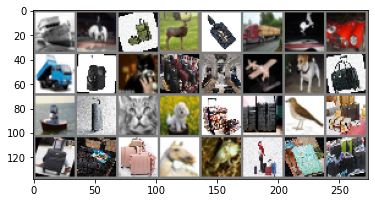

tensor([1, 1, 0, 1, 0, 1, 1, 1])
tensor([1, 0, 1, 0, 0, 1, 1, 0])
tensor([1, 0, 1, 1, 0, 0, 1, 0])
tensor([0, 0, 0, 1, 1, 0, 0, 0])


In [6]:
%matplotlib inline
labels = show_random_images(train_loader)
for i in range(4):
    print(labels[i*8:(i+1)*8])

In [7]:
# Instantiate the model
model = Model()
print(model)

Model(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (

In [8]:
# Instantiate a trainer with a GPU, training for 3 epochs
trainer = pl.Trainer(gpus=1, max_epochs=3)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [9]:
# Train the model
trainer.fit(model, train_loader, test_loader)


  | Name     | Type   | Params
------------------------------------
0 | backbone | ResNet | 23 M  
Epoch 1:  90%|█████████ | 252/280 [00:20<00:02, 12.57it/s, loss=0.010, v_num=9, val_loss=0.0517, val_acc=0.987]
Validating: 0it [00:00, ?it/s]
Epoch 2:  90%|█████████ | 252/280 [00:20<00:02, 12.32it/s, loss=0.022, v_num=9, val_loss=0.0142, val_acc=0.998]
Validating: 0it [00:00, ?it/s]
Epoch 2: 100%|██████████| 280/280 [00:25<00:00, 11.20it/s, loss=0.022, v_num=9, val_loss=0.0106, val_acc=0.996]


1